Построение модели классификации

Обзор обучающего датасета
Обработка выбросов
Обработка пропусков

Анализ данных
Отбор признаков
Балансировка классов

Подбор моделей, получение бейзлана
Выбор наилучшей модели, настройка гиперпараметров
Проверка качества, борьба с переобучением
Интерпретация результатов
Прогнозирование на тестовом датасете

Выполнить для тестового датасета те же этапы обработки и постронияния признаков
Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
Соблюдать исходный порядок примеров из тестового датасета

In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
train_path = '/home/polmura/GeekBrains/Python_libs_2/course_project/course_project_train.csv'
test_path = '/home/polmura/GeekBrains/Python_libs_2/course_project/course_project_test.csv'

# Данные

In [43]:
df_train = pd.read_csv(train_path)
features = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
        'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Default']
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Размерность датасета**

In [44]:
df_train.shape

(7500, 17)

**Количественные признаки**

In [45]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Целевая переменная**

In [46]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Тестовый датасет**

df_test = pd.read_csv(test_path)
df_test.info()

**Размерность**

df_test.shape

**Номинативные признаки**

In [47]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Приведение номинативных признаков**

In [48]:
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df_train[colname] = df_train[colname].astype(str)

# Пропуски

In [19]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Home Ownership - домовладение
Annual Income - годовой доход
Years in current job - количество лет на текущем месте работы
Tax Liens - налоговые обременения
Number of Open Accounts - количество открытых счетов
Years of Credit History - количество лет кредитной истории
Maximum Open Credit - наибольший открытый кредит
Number of Credit Problems - количество проблем с кредитом
Months since last delinquent - количество месяцев с последней просрочки платежа
Bankruptcies - банкротства
Purpose - цель кредита
Term - срок кредита
Current Loan Amount - текущая сумма кредита
Current Credit Balance - текущий кредитный баланс
Monthly Debt - ежемесячный долг
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

df_train.info()

for num_colname in df_train.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_train[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

**выбросы не определены**

**Обработка ID**

In [49]:
df_train['ID'] = df_train.index.tolist()

# **Выделение целевой переменной и отбор признаков**

In [24]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies']
NEW_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']
#NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

**Корреляция**

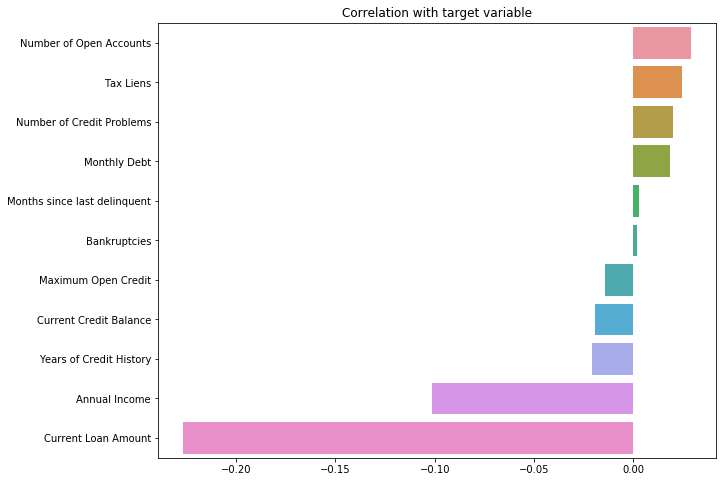

In [25]:
corr_with_target = df_train[FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

'Months since last delinquent', 'Bankruptcies' - не включаем в новый список фич

**Оценка номинативных признаков в разрезе целевой переменной**

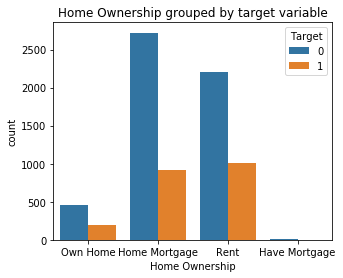

In [23]:
plt.figure(figsize=(5, 4))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df_train)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [50]:
ho_and_target_s = df_train.loc[df_train['Home Ownership'].isin([-1, 0]), ['ID', 'Home Ownership', 'Credit Default']].sample(1000)

ValueError: 'a' must be greater than 0 unless no samples are taken

In [ ]:
table = pay1_and_target_s.pivot_table(values='ID', index='Home Ownership', columns='Credit Default', aggfunc='count')
table

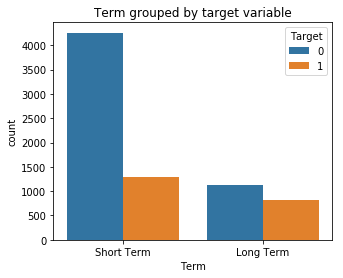

In [33]:
plt.figure(figsize=(5, 4))

sns.countplot(x="Term", hue=TARGET_NAME, data=df_train)
plt.title('Term grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

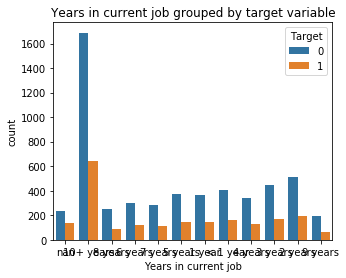

In [34]:
plt.figure(figsize=(5, 4))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

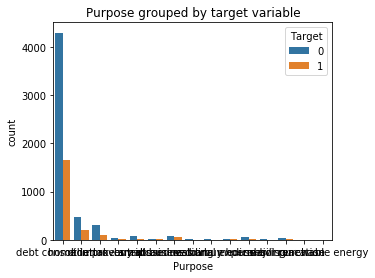

In [35]:
plt.figure(figsize=(5, 4))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()